# GPT2 Training Notebook

This notebook converts the raw data files into JSON format and trains the GPT2 model on those data. 

## Imports and Setups

In [1]:
import argparse
from datetime import datetime
import os
import json
import pandas as pd
import time
import matplotlib.pyplot as plt

import numpy as np
from transformers import GPT2LMHeadModel,AdamW, WarmupLinearSchedule
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tnrange, tqdm_notebook

from dataset import GPT21024Dataset 
from utils import add_special_tokens, generate_sample, set_seed

## Processing Raw Data

If this is the first time you are running GPT2 training on your device, then it is necessary to run this section. 

First, place the file "pubmed_gene_go_summary.tsv" under the directory "./pubmed" so it can be read. Then run the cell below. It will read the file as dataframe and print the shape of the resulting dataframe. 

In [2]:
filename = "pubmed_gene_go_summary.tsv"
path = os.path.join("pubmed", filename)
pubmed_table = pd.read_csv(path, sep = "\t")
pubmed_table = pubmed_table[pubmed_table['Abstract'].notna()]
pubmed_table = pubmed_table[pubmed_table['Title'].notna()]
pubmed_table = pubmed_table[pubmed_table['Target'].notna()]
pubmed_table.shape

(7652, 5)

To check how the dataframe looks like: 

In [3]:
pubmed_table.head(5)

,GeneID,PubMed,Target,Title,Abstract
0,12,14668352,SERPINA3 enables DNA binding; located_in nucleus.,The SANT2 domain of the murine tumor cell DnaJ...,The murine tumor cell DnaJ-like protein 1 or M...
1,64215,14668352,DNAJC1 enables ATPase activator activity; invo...,The SANT2 domain of the murine tumor cell DnaJ...,The murine tumor cell DnaJ-like protein 1 or M...
2,12,2404007,SERPINA3 enables serine-type endopeptidase inh...,"Cloning, expression, purification, and biologi...",Human alpha 1-antichymotrypsin has been cloned...
3,13,11481320,AADAC enables lipase activity.,Characterization of the rodent genes for aryla...,"In the current study, we have determined the c..."
4,13,8063807,AADAC enables catalytic activity.,Human liver arylacetamide deacetylase. Molecul...,Microsomal arylacetamide deacetylase (DAC) com...


Now run the following cells to create JSON files ready for training: 

In [8]:
def write_json(i, article, abstract):
    """ Saves a json file."""

    file = "./pubmed/gpt2_1024_data/"+str(i)+".json"
    js_example = {}
    js_example['id'] = i
    js_example['article'] = article
    js_example['abstract'] = abstract
    with open(file, 'w') as f:
        json.dump(js_example, f, ensure_ascii=False)

In [9]:
tokenizer = add_special_tokens()
train_ids = []
#file_id_map = {}
sizes = []
for index, row in pubmed_table.iterrows():
    article = row["Title"] + " " + row["Abstract"]
    summary = row["Target"]
    article = tokenizer.encode(article)
    summary = tokenizer.encode(summary)
    sizes.append(len(article) + len(summary))
    if len(article) > 0 and len(summary) > 0 and (len(article) + len(summary) <= 1023):
        train_ids.append(index)
        write_json(index, article, summary)
        #file_id_map[i] = os.path.basename(file).replace('.story', '')
        if index%100==0:
            print(index, " files written")
            
x,y = int(len(train_ids)*0.8), int(len(train_ids)*0.9)
valid_ids = train_ids[x:y]
test_ids = train_ids[y:]
train_ids = train_ids[:x]
with open("./pubmed/ids.json",'w') as f:
    js = {}
    js['train_ids'] = train_ids
    js['valid_ids'] = valid_ids
    js['test_ids'] = test_ids
    json.dump(js,f)


0  files written
100  files written
200  files written
300  files written
400  files written
500  files written
600  files written
700  files written
800  files written
900  files written
1000  files written
1100  files written
1200  files written
1400  files written
1500  files written
1600  files written
1700  files written
1800  files written
1900  files written
2000  files written
2100  files written
2200  files written
2300  files written
2400  files written
2500  files written
2600  files written
2700  files written
2800  files written
2900  files written
3000  files written
3100  files written
3200  files written
3300  files written
3400  files written
3500  files written
3600  files written
3700  files written
3800  files written
3900  files written
4000  files written
4100  files written
4200  files written
4300  files written
4400  files written
4500  files written
4600  files written
4700  files written
4800  files written
4900  files written
5000  files written
5100  files 

To check the lengths of each article: 

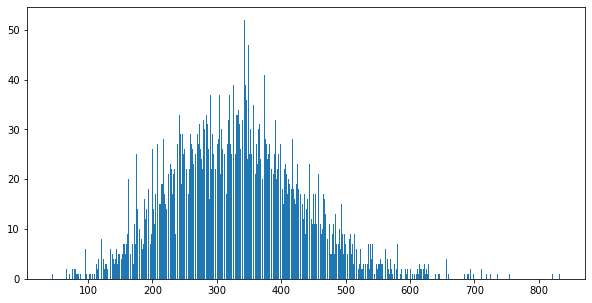

In [10]:
fig = plt.figure(figsize = (10, 5))

keys, counts = np.unique(sizes, return_counts=True)

plt.bar(keys, counts)
plt.show()

In the above diagram, the x-axis represents the length of article, and the y-axis represents the count of articles that are of those length. 

## Training

Cells below are the training process. 

### Define parameters

Most of these diameters follow the most optimal parameters mentioned in the original article. The only changes made were: 
1. args.batch_size changed from 1 to 3
2. args.device changed from 'cpu' to 'cuda'

In [2]:
#please change default arguments if needed

parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-5, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=32, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=3, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=4, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cuda'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=5, type=int,  help="no of epochs of training")
parser.add_argument("--output_dir",default='./output', type=str,  help="path to save evaluation results")
parser.add_argument("--model_dir",default='./weights', type=str,  help="path to save trained model")
parser.add_argument("--max_grad_norm",default=1.0, type=float, help="max gradient norm.")
parser.add_argument("--root_dir",default='./pubmed/gpt2_1024_data', type=str, help="location of json dataset.")
parser.add_argument("--ids_file",default='./pubmed/ids.json', type=str, help="location of train, valid and test file indexes")
args = parser.parse_args([])
print(args)

Namespace(lr=5e-05, seed=42, n_gpu=1, gradient_accumulation_steps=32, batch_size=3, num_workers=4, device=device(type='cuda'), num_train_epochs=5, output_dir='./output', model_dir='./weights', max_grad_norm=1.0, root_dir='./pubmed/gpt2_1024_data', ids_file='./pubmed/ids.json')


It is worth noting that the authors of the original paper also admits that the best parameters that they found may not be the absolutely most optimal, as they would need more studies to find it. Also they were training on news articles, so depending on the domain difference, there may be a different set of parameters that are more suited for us. 

### Define training & evaluating function

Lightly modified compared to the original. Made to have them compatible with situations where batch_size > 1. I used the mean value of loss across a batch as the loss to perform backward propagation. 

You can refer to train_gpt2_summarizer_np.ipynb to see the original functions. 

In [1]:
def train(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    """ Trains GPT2 model and logs necessary details.
        Args:
            args: dict that contains all the necessary information passed by user while training
            model: finetuned gpt/gpt2 model
            tokenizer: GPT/GPT2 tokenizer
            train_dataset: GPT21024Dataset object for training data
            ignore_index: token not considered in loss calculation
    """
    writer = SummaryWriter('./output/logs')
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset,sampler=train_sampler,batch_size=args.batch_size,num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer,200,80000)
    loss_trace = {}
    val_loss_trace = {}

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
            model.train()
            logits = model(inputs)[0]
            # only consider loss on reference summary just like seq2seq models
            # Modification starts here
            loss = 0
            for idx in batch['sum_idx']:
                shift_logits = logits[..., idx:-1, :].contiguous()
                shift_labels = labels[..., idx+1:].contiguous()
                loss_single = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                loss_single = loss_single/args.gradient_accumulation_steps
                loss += loss_single
            loss = loss / args.batch_size
            # Modification stops here
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                loss_trace[global_step] = loss.item()
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample(valid_dataset, tokenizer, model, num=2, eval_step=False,device=args.device)
                
                
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results, val_loss = evaluate(args, model, valid_dataset, ignore_index, global_step)
                val_loss_trace[global_step] = val_loss
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, model, num=2, eval_step=True, device=args.device)
                
    return loss_trace, val_loss_trace


In [2]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    """ Returns perplexity score on validation dataset.
        Args:
            args: dict that contains all the necessary information passed by user while training
            model: finetuned gpt/gpt2 model
            eval_dataset: GPT21024Dataset object for validation data
            global_step: no. of times gradients have backpropagated
            ignore_index: token not considered in loss calculation
    """
    if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)
    eval_output_dir = args.output_dir

    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
        
        
        with torch.no_grad():
            logits = model(inputs)[0]
            # only consider loss on reference summary just like seq2seq models
            # Modification starts here
            lm_loss = 0
            for idx in batch['sum_idx']:
                shift_logits = logits[..., idx:-1, :].contiguous()
                shift_labels = labels[..., idx+1:].contiguous()
                lm_loss += loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            lm_loss = lm_loss / args.batch_size
            # Modification stops here
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    if global_step:
        output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
        with open(output_eval_file, "a") as f:
            for key in sorted(result.keys()):
                f.write('\n\n')
                f.write("time = %s, %s = %s, step = %s\n" % (datetime.now().strftime("%d/%m/%Y %H:%M:%S"), key, str(result[key]), str(global_step)))
    return result, eval_loss           

### Define training/validation/test sets

They are divided by 8:1:1 ratio. 

In [5]:
# creating training and validation dataset object

train_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='train',length=6100) #training on only 6100 datasets
valid_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='valid',length=770)  #validation on only 700 datasets
test_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='test',length=770)  #Testing on only 700 datasets


### Load pretrained GPT2 model

In [ ]:
# load pretrained GPT2
tokenizer = add_special_tokens()
ignore_idx = tokenizer.pad_token_id
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(args.device)

### Start training process

In [8]:
#training the model

start = time.time()
#loss_trace, val_loss_trace = train(args, model, tokenizer, train_data, valid_data, ignore_idx)
loss_trace = train(args, model, tokenizer, train_data, valid_data, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')

print('Saving trained model...')
model_file = os.path.join(args.model_dir, 'model_data{}_trained_after_{}_epochs_only_sum_loss_ignr_pad.bin'.format(len(train_data),args.num_train_epochs))
config_file = os.path.join(args.model_dir, 'config_data{}_trained_after_{}_epochs_only_sum_loss_ignr_pad.json'.format(len(train_data),args.num_train_epochs))
torch.save(model.state_dict(), model_file)
model.config.to_json_file(config_file)

/tmp/ipykernel_3410850/2088881563.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_3410850/2088881563.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dl, desc="Training")


Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 2.1977221965789795

After 1st update: 



/home/rli10/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
/home/rli10/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains o

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wo

/tmp/ipykernel_3410850/3668365262.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 9.828721051508936e+30
After 11 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 1.913456551414295e+24
After 21 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 21180358590464.0
After 31 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 59783400.0
After 41 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 290004.03125
After 51 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 542.622802734375
After 61 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 142.8739471435547
After 71 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 85.63660430908203
After 81 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 99.36616516113281
After 91 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 537.0595703125
After 101 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 23.442285537719727
After 111 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 16.276601791381836
After 121 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 27.249263763427734
After 131 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 88.63519287109375
After 141 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 24.76390838623047
After 151 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 9.38344669342041
After 161 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.755002975463867
After 171 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.362332344055176
After 181 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.234370231628418
After 191 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.10511346161365509

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains o

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wo

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.121988296508789
After 201 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.159476280212402
After 211 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.046055793762207
After 221 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.9489874839782715
After 231 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.150518417358398
After 241 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.854088306427002
After 251 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.611605167388916
After 261 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.6628947257995605
After 271 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.784651756286621
After 281 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.76729679107666
After 291 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.04916000366211
After 301 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.390017986297607
After 311 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.962398052215576
After 321 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.0569024085998535
After 331 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.179736614227295
After 341 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.385754108428955
After 351 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.302957057952881
After 361 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.0893425941467285
After 371 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.108158588409424
After 381 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.042024001479148865

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains o

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wo

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.112054347991943
After 391 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.166232109069824
After 401 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.106551170349121
After 411 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.037003040313721
After 421 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.029886722564697
After 431 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.197864532470703
After 441 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.059006690979004
After 451 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.048745632171631
After 461 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.017761707305908
After 471 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.9438347816467285
After 481 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.889359951019287
After 491 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.8287882804870605
After 501 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.721691608428955
After 511 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.575432300567627
After 521 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.730771064758301
After 531 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.797608852386475
After 541 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.572558879852295
After 551 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.641722679138184
After 561 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.866762638092041
After 571 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.07410638779401779

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains o

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wo

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.579398155212402
After 581 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.545793056488037
After 591 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.623549461364746
After 601 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.6547346115112305
After 611 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.611043453216553
After 621 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.6118035316467285
After 631 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.587007522583008
After 641 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.3159918785095215
After 651 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.299841403961182
After 661 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.3822855949401855
After 671 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.382480621337891
After 681 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.291130542755127
After 691 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.12506628036499
After 701 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.960903167724609
After 711 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.924025058746338
After 721 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.959100246429443
After 731 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.948307514190674
After 741 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.9801812171936035
After 751 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.923156261444092
After 761 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.06195450574159622

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains o

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wo

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.160376071929932
After 771 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.184394359588623
After 781 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.205316543579102
After 791 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.881106853485107
After 801 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.77602481842041
After 811 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.846427917480469
After 821 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.822363376617432
After 831 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.775207042694092
After 841 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.690581798553467
After 851 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.735513687133789
After 861 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.83333158493042
After 871 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.744576930999756
After 881 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.764747142791748
After 891 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.678309440612793
After 901 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.632075309753418
After 911 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.620319843292236
After 921 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.814483165740967
After 931 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.725273132324219
After 941 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.518779754638672
After 951 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

The peptide repeat domain of nucleoporin Nup98 functions as a docking site in transport across the nuclear pore complex. We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucle

  0%|          | 0/100 [00:00<?, ?it/s]

The CXC chemokine stromal cell-derived factor activates a Gi-coupled phosphoinositide 3-kinase in T lymphocytes. The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and 

The log above is ran with args.batch_size = 1. 

With batch_size = 3, the training time is 2/3 of the time it takes when batch_size = 1. (Around 55 minutes) 

## Examine the loss curve

The blue curve is the training loss, and the orange is the validation loss. 

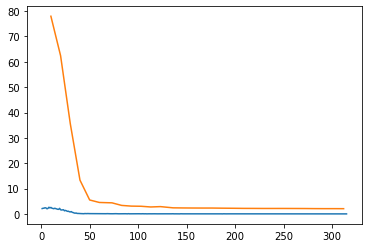

In [9]:
loss_trace_list = sorted(loss_trace[0].items())
train_time, train_loss = zip(*loss_trace_list)
# The above 2 lines should be re-ran after training. Now the kernel has loss_trace as the actual list. 
val_loss_trace_list = sorted(loss_trace[1].items())
val_time, val_loss = zip(*val_loss_trace_list)


plt.plot(train_time, train_loss)
plt.plot(val_time, val_loss)

There is a discrepancy between the graph and the training log above. The training log was later ran with args.batch_size = 1, while the graph was created when args.batch_size = 3. 

In the above graph, the y-axis represents loss value, and the x-axis represents every "gradient accumulation step" in the training process.  

Since in this case args.gradient_accumulation_step = 32, each tick in the x-axis means 32 steps, with each step going over 3 data points in a batch (args.batch_size = 3). So, assuming there are 325 ticks on the graph above, the training process trained over 325 * 32 * 3 = 31200 data points. Since there are 5 epochs, 31200 / 5 = 6240, which is approximately the length of out training set. 

## Results

After training and saving the trained model in './weights', we can open 'play_with_summarizer.ipynb' to see what kind of summary the model can generate. 